**Step 0 - install and import dependencies**

In [6]:
!pip install pythainlp
!pip install tensorflow_text
!pip install umap-learn

In [7]:
import numpy as np
import pandas as pd
import re

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text
import umap

from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

from sklearn.cluster import AgglomerativeClustering
from sklearn.neighbors import kneighbors_graph

import pythainlp
from pythainlp.corpus.common import thai_words
from pythainlp.util import Trie
import collections


In [8]:
module_url = 'https://tfhub.dev/google/universal-sentence-encoder-multilingual/3' #'https://tfhub.dev/google/universal-sentence-encoder-multilingual/3' for a large model

model = hub.load(module_url)

In [9]:
df = pd.read_csv("/content/sample_data/Wongnai Reviews - Small.csv")

In [10]:
df.head()

,Review ID,Review
0,1,เป็นคนที่ชอบทาน Macchiato เป็นประจำ มีวันนึงเด...
1,2,Art of Coffee Kasetsart เป็นร้านกาแฟรสชาติเยี่...
2,3,กวงทะเลเผา อาหารทะเลเค้าสดจริงๆเนื้อปูหวานไม่ค...
3,4,วันนี้มีโอกาสตื่นเช้าครับเลยถึงโอกาสออกมาหาอะไ...
4,5,ชอบมาทานร้านนี้ถ้าอยากกินอาหารเวียดนามใกล้บ้าน...


**Step 1 - document embedding and dimension reduction**

In [11]:
#embed sentences using Universal Sentence Encoder (USE)

embed_comments_array = model(df['Review'].values).numpy()
embed_comments_array

array([[ 0.08993827,  0.01941084,  0.03787038, ..., -0.03488849,
         0.06299512,  0.04635989],
       [ 0.00634244,  0.00814594,  0.03071941, ..., -0.01478723,
        -0.03080936, -0.03316405],
       [ 0.0633687 , -0.02027139, -0.05077003, ..., -0.06530775,
        -0.00952999, -0.03439987],
       ...,
       [ 0.08775924,  0.03609736,  0.01263062, ..., -0.03102781,
        -0.03361677,  0.01928871],
       [ 0.05691195,  0.05381691, -0.0399575 , ..., -0.06598807,
        -0.05390478, -0.01037725],
       [ 0.0777048 ,  0.05080631,  0.02680681, ..., -0.0061413 ,
        -0.01313567,  0.02236264]], dtype=float32)

In [12]:
#reduce array dimensions using umap (you can chagne n_components)

reducer = umap.UMAP(random_state=42,n_components=50)
umap_embed_comments_array = reducer.fit_transform(embed_comments_array)

/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


**Step 2 - document clustering using KMeans**

Text(0, 0.5, 'WCSS')

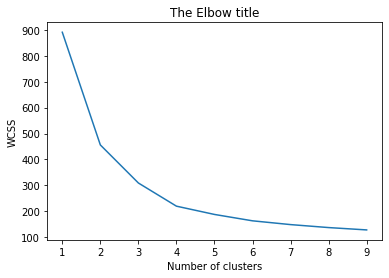

In [13]:
#run kmeans with various number of k. evaluate no. of k based on the elbow plot

wcss=[]
max_k = 10
for i in range(1, max_k):
  kmeans = KMeans(i)
  kmeans.fit(umap_embed_comments_array)
  wcss_iter = kmeans.inertia_
  wcss.append(wcss_iter)

number_clusters = range(1, max_k)
plt.plot(number_clusters,wcss)
plt.title('The Elbow title')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')

In [14]:
#run kmeans with no. of clusters you see fit the most

k = 4

kmeans = KMeans(n_clusters = k)
kmeans.fit(umap_embed_comments_array)

df['KMeans ID'] = kmeans.labels_

In [15]:
#merge all reviews of each cluster into one big sentence 

df_kmeans = pd.DataFrame(columns=["KMeans ID", "texts"])


for i in range(0, k):
  row = []
  row.append(i)
  row.append(df['Review'][df['KMeans ID'] == i].to_string())
  df_kmeans.loc[len(df_kmeans)] = row

In [16]:
df_kmeans

,KMeans ID,texts
0,0,13 เคยเป็นไหมกันไหมคะ หลังอาหารมื้อใหญ่ ต่...
1,1,0 เป็นคนที่ชอบทาน Macchiato เป็นประจำ มีว...
2,2,2 กวงทะเลเผา อาหารทะเลเค้าสดจริงๆเนื้อปูห...
3,3,3 วันนี้มีโอกาสตื่นเช้าครับเลยถึงโอกาสออก...


In [17]:
#create regex compiler for removal of a character you don't want

special_characters = "/[!@#$%^&*']/g"

specialchar_pattern = re.compile(special_characters)

In [18]:
#create regex compiler for removal of any emoji

emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags=re.UNICODE)

In [19]:
#create regex compiler for removal of digit

number_pattern = re.compile("[0-9]")

In [20]:
#create regex compiler for removal of white space

space_pattern = re.compile("\s+")

In [21]:
#create regex compiler for removal of .

dot_pattern = re.compile(r"\.+")

In [22]:
#create regex compiler for removal of \

backslash_pattern = re.compile(r"\\+")

In [33]:
#define a function to tokenize a sentence into words - you can define words you want to remove as well as new words for tokenization

stopwords = list(pythainlp.corpus.thai_stopwords())
removed_words = ['u', 'b', 'n', 'nn', 'nn-', '\n', 'ร้าน']
screening_words = stopwords + removed_words

new_words = {"สตารบัก","เค้าดาว","ชานมไข่มุก","อเมซอน","หัวหิน","ราชเทวี"}

words = new_words.union(thai_words())

custom_dictionary_trie = Trie(words)

def tokenize_to_list(sentence):
  merged = []
  words = pythainlp.word_tokenize(str(sentence), engine='newmm', custom_dict=custom_dictionary_trie)
  for word in words:
    if word not in screening_words:
      merged.append(word)
  return merged

In [34]:
#clean and tokenize sentences. count the occurences of each word

df_kmeans['texts'] = df_kmeans['texts'].apply(lambda x: emoji_pattern.sub(r'', x))
df_kmeans['texts'] = df_kmeans['texts'].apply(lambda x: specialchar_pattern.sub(r'', x))
df_kmeans['texts'] = df_kmeans['texts'].apply(lambda x: number_pattern.sub(r'', x))
df_kmeans['texts'] = df_kmeans['texts'].apply(lambda x: space_pattern.sub(r'', x))
df_kmeans['texts'] = df_kmeans['texts'].apply(lambda x: dot_pattern.sub(r'', x))
df_kmeans['texts'] = df_kmeans['texts'].apply(lambda x: backslash_pattern.sub(r'', x))
df_kmeans['texts_tokenized'] = df_kmeans['texts'].apply(lambda x: tokenize_to_list(x))
df_kmeans['texts_count'] = df_kmeans['texts_tokenized'].apply(lambda x: collections.Counter(x).most_common())

In [35]:
#results of tokenization

df_kmeans

,KMeans ID,texts,texts_tokenized,texts_count
0,0,เคยเป็นไหมกันไหมคะหลังอาหารมื้อใหญ่ต่อให้อิ่เช...,"[ไหม, ไหม, หลังอาหาร, มื้อ, ต่อให้, อิ่, เช้า,...","[(ชา, 9), (ชานมไข่มุก, 9), (ทาน, 6), (ไข่มุก, ..."
1,1,เป็นคนที่ชอบทานMacchiatoเป็นประจำมีวันนึงเดArt...,"[คน, ชอบ, ทาน, Macchiato, เป็นประจำ, นึง, เด, ...","[(ร้านกาแฟ, 22), (กาแฟ, 19), (ทาน, 11), (ชอบ, ..."
2,2,กวงทะเลเผาอาหารทะเลเค้าสดจริงๆเนื้อปูหวานไม่คส...,"[กวง, ทะเล, เผา, อาหารทะเล, เค้า, สด, เนื้อ, ป...","[(ร้านอาหาร, 11), (กก, 7), (กิน, 7), (อร่อย, 6..."
3,3,วันนี้มีโอกาสตื่นเช้าครับเลยถึงโอกาสออกมาหาอะไ...,"[มีโอกาส, ตื่น, เช้า, โอกาส, มาหา, อะ, ไช, อบ,...","[(กิน, 10), (อร่อย, 9), (ทาน, 7), (ผม, 7), (รี..."


In [36]:
#show top keywords of each cluster

top_N_words = 10

for i in range(0, len(df_kmeans)):
  print(f"Cluster ID : {i}\n")
  print(f"Most common words include : {list(df_kmeans['texts_count'][i])[:top_N_words]}\n")

#tune a model by remove unwanted characters and words and add more words to a custom dictionary

Cluster ID : 0

Most common words include : [('ชา', 9), ('ชานมไข่มุก', 9), ('ทาน', 6), ('ไข่มุก', 5), ('นม', 5), ('เครื่องดื่ม', 4), ('ร้า', 3), ('ตั้งอยู่', 3), ('รีวิว', 3), ('ลอง', 3)]

Cluster ID : 1

Most common words include : [('ร้านกาแฟ', 22), ('กาแฟ', 19), ('ทาน', 11), ('ชอบ', 8), ('คาเฟ่', 6), ('กิน', 6), ('แวะ', 6), ('น่ารัก', 5), ('น', 5), ('นั่ง', 5)]

Cluster ID : 2

Most common words include : [('ร้านอาหาร', 11), ('กก', 7), ('กิน', 7), ('อร่อย', 6), ('ซอย', 6), ('อาหาร', 6), ('ทาน', 5), ('ราคา', 5), ('สวัสดี', 4), ('เพื่อน', 4)]

Cluster ID : 3

Most common words include : [('กิน', 10), ('อร่อย', 9), ('ทาน', 7), ('ผม', 7), ('รีวิว', 7), ('บ้าน', 5), ('ร้านกาแฟ', 5), ('กาแฟ', 5), ('กก', 5), ('อาหาร', 4)]



In [37]:
df_kmeans['texts_count'][3]

[('กิน', 10),
 ('อร่อย', 9),
 ('ทาน', 7),
 ('ผม', 7),
 ('รีวิว', 7),
 ('บ้าน', 5),
 ('ร้านกาแฟ', 5),
 ('กาแฟ', 5),
 ('กก', 5),
 ('อาหาร', 4),
 ('ชอบ', 4),
 ('ร้านอาหาร', 4),
 ('มีโอกาส', 3),
 ('ถนน', 3),
 ('คิว', 3),
 ('กา', 3),
 ('ศ', 3),
 ('ครั้งแรก', 3),
 ('ซื้อ', 3),
 ('นะคะ', 3),
 ('เลือก', 3),
 ('บอ', 3),
 ('ลอง', 3),
 ('หา', 3),
 ('ดี', 3),
 ('น้ำ', 3),
 ('สาขา', 3),
 ('เช้า', 2),
 ('โอกาส', 2),
 ('สะดุดตา', 2),
 ('ปากซอย', 2),
 ('เค้า', 2),
 ('ดาว', 2),
 ('รู้จัก', 2),
 ('เมนู', 2),
 ('เก', 2),
 ('เดิน', 2),
 ('เกริ่น', 2),
 ('ๆๆ', 2),
 ('ทะเล', 2),
 ('ไอติม', 2),
 ('เค', 2),
 ('พูดถึง', 2),
 ('สำหรับ', 2),
 ('อย่า', 2),
 ('ชื่อ', 2),
 ('เวลา', 2),
 ('คน', 2),
 ('เด็ด', 2),
 ('ค', 2),
 ('เป็ร้าน', 2),
 ('ขา', 2),
 ('ขนมปัง', 2),
 ('ยา', 2),
 ('ไปมา', 2),
 ('ปีใหม่', 2),
 ('ก', 2),
 ('รี่', 2),
 ('ส้มตำ', 2),
 ('ก๋วยเตี๋ยว', 2),
 ('สั่ง', 2),
 ('ร', 2),
 ('ปั่น', 2),
 ('แตงโม', 2),
 ('เดินเล่น', 2),
 ('อี', 2),
 ('กร้าน', 2),
 ('สวัสดี', 2),
 ('ตื่น', 1),
 ('มาหา', 1),
 ('อะ', 1

**Step 3 - document clustering using Agglomorative Clustering with cosine similarity**

In [38]:
#clustering using agglomorative clustering

knn_graph = kneighbors_graph(embed_comments_array, 5, include_self=False)
model = AgglomerativeClustering(linkage="average", connectivity=knn_graph, n_clusters=10, affinity="cosine")
model.fit(embed_comments_array)
df['Agglomerative ID'] = model.labels_

In [39]:
#merge all reviews of each cluster into one big sentence 

df_Agglomerative = pd.DataFrame(columns=["Agglomerative ID", "texts"])


for i in range(0, k):
  row = []
  row.append(i)
  row.append(str(df['Review'][df['Agglomerative ID'] == i].tolist()))
  df_Agglomerative.loc[len(df_Agglomerative)] = row

In [40]:
#clean and tokenize sentences. count the occurences of each word

df_Agglomerative['texts'] = df_Agglomerative['texts'].apply(lambda x: emoji_pattern.sub(r'', x))
df_Agglomerative['texts'] = df_Agglomerative['texts'].apply(lambda x: specialchar_pattern.sub(r'', x))
df_Agglomerative['texts'] = df_Agglomerative['texts'].apply(lambda x: number_pattern.sub(r'', x))
df_Agglomerative['texts'] = df_Agglomerative['texts'].apply(lambda x: space_pattern.sub(r'', x))
df_Agglomerative['texts'] = df_Agglomerative['texts'].apply(lambda x: dot_pattern.sub(r'', x))
df_Agglomerative['texts'] = df_Agglomerative['texts'].apply(lambda x: backslash_pattern.sub(r'', x))
df_Agglomerative['texts_tokenized'] = df_Agglomerative['texts'].apply(lambda x: tokenize_to_list(x))
df_Agglomerative['texts_count'] = df_Agglomerative['texts_tokenized'].apply(lambda x: collections.Counter(x).most_common())

In [41]:
#show top keywords of each cluster

top_N_words = 10

for i in range(0, len(df_Agglomerative)):
  print(f"Cluster ID : {i}\n")
  print(f"Most common words include : {list(df_Agglomerative['texts_count'][i])[:top_N_words]}\n")

Cluster ID : 0

Most common words include : [('อร่อย', 508), ('ทาน', 416), ('รสชาติ', 407), ('ดี', 347), ('กิน', 339), ('กาแฟ', 311), ('เมนู', 309), ('สั่ง', 301), ('อาหาร', 285), ('ราคา', 273)]

Cluster ID : 1

Most common words include : [('แตงโม', 22), ('น้ำ', 8), ('ปั่น', 6), ('เนื้อ', 6), ('เลือก', 4), ('ซื้อ', 4), ('ดื่ม', 4), ('พันธุ์', 3), ('รับประทาน', 3), ('แก้', 3)]

Cluster ID : 2

Most common words include : [('ดิชั้น', 4), ('แย่มาก', 3), ('โต๊ะ', 2), ('รอง', 2), ('แก้ว', 2), ("['", 1), ('ดิ', 1), ('ช้ัน', 1), ('ทบ', 1), ('น', 1)]

Cluster ID : 3

Most common words include : [('นม', 3), ('แน่น', 2), ('tamp', 2), ('เท', 2), ('แก้', 2), ("['", 1), ('เรื่อง', 1), ('ขนม', 1), ('สันทัด', 1), ('ดังนั้น', 1)]



**Step 4 - result discussion**

Summary :
หลังจากทำ text tokenize แล้วพบว่ามีบางคำที่มีการแบ่งคำไม่ถูกต้องเพิ่มเติม นอกเหนือจาก สตาร์บัค จึงเพิ่มคำว่า "เค้าดาว","ชานมไข่มุก","อเมซอน","หัวหิน","ราชเทวี และใช้ K-Means ในการสรุปผลดังนี้ครับ

Cluster ID : 0 -> เป็นการีวิวกลุ่มร้านชานมไข่มุก

Most common words include : [('ชา', 9), ('ชานมไข่มุก', 9), ('ทาน', 6), ('ไข่มุก', 5), ('นม', 5), ('เครื่องดื่ม', 4), ('ร้า', 3), ('ตั้งอยู่', 3), ('รีวิว', 3), ('ลอง', 3)]

Cluster ID : 1 -> เป็นการีวิวกลุ่มร้านกาแฟ

Most common words include : [('ร้านกาแฟ', 22), ('กาแฟ', 19), ('ทาน', 11), ('ชอบ', 8), ('คาเฟ่', 6), ('กิน', 6), ('แวะ', 6), ('น่ารัก', 5), ('น', 5), ('นั่ง', 5)]

Cluster ID : 2  -> เป็นการีวิวกลุ่มร้านอาหารที่เน้นทานกับเพื่อนๆ

Most common words include : [('ร้านอาหาร', 11), ('กก', 7), ('กิน', 7), ('อร่อย', 6), ('ซอย', 6), ('อาหาร', 6), ('ทาน', 5), ('ราคา', 5), ('สวัสดี', 4), ('เพื่อน', 4)]

Cluster ID : 3  -> เป็นการีวิวกลุ่มร้านอาหารช่วงปีใหม่

Most common words include : [('กิน', 10), ('อร่อย', 9), ('ทาน', 7), ('ผม', 7), ('รีวิว', 7), ('บ้าน', 5), ('ร้านกาแฟ', 5), ('กาแฟ', 5), ('กก', 5), ('อาหาร', 4)]

Remark : เจอคำว่ามากกก เยอะเหมือนกัน อยากตัดออกแต่ทำไม่ทันครับ T__T